In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
#from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

## Downloading Data

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
    print(_)
    print(filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


## Converting data to a string

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


## Building the Vocabulary (Dictionaries)

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


## Generating batches of data

Unlike data in skip-gram, here data is of following sizes
* batch: [batch_size, context_window size - 1] # words found in the context
* labels: [batch_size, 1] # target word (word to be predicted)

In [5]:
data_index = 0

def generate_batch(batch_size, skip_window):
    # skip window is the amount of words we're looking at from each side of a given word
    # creates a single batch
    global data_index

    span = 2 * skip_window + 1 # [ skip_window target skip_window ]

    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # e.g if skip_window = 2 then span = 5
    # span is the length of the whole frame we are considering for a single word (left + word + right)
    # skip_window is the length of one side

    # queue which add and pop at the end
    buffer = collections.deque(maxlen=span)

    #get words starting from index 0 to span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # num_skips => # of times we select a random word within the span?
    # batch_size (8) and num_skips (2) (4 times)
    # batch_size (8) and num_skips (1) (8 times)
    for i in range(batch_size):
        target = skip_window  # target label at the center of the buffer
        target_to_avoid = [ skip_window ] # we only need to know the words around a given word, not the word itself

        # do this num_skips (2 times)
        # do this (1 time)

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            if j==span//2:
                continue
            # e.g. i=0, j=0 => 0; i=0,j=1 => 1; i=1,j=0 => 2
            batch[i,col_idx] = buffer[j] # [skip_window] => middle element
            col_idx += 1
        labels[i, 0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels



for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with num_skips = 2 and skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Running Embedding Learning

In [6]:
num_steps = 100000

if __name__ == '__main__':
    batch_size = 128
    embedding_size = 128 # Dimension of the embedding vector.
    skip_window = 1 # How many words to consider left and right.
    num_skips = 2 # How many times to reuse an input to generate a label.
    # We pick a random validation set to sample nearest neighbors. here we limit the
    # validation samples to the words that have a low numeric ID, which by
    # construction are also the most frequent.
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100 # Only pick dev samples in the head of the distribution.
    # pick 16 samples from 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))
    num_sampled = 64 # Number of negative examples to sample.

    graph = tf.Graph()

    with graph.as_default(), tf.device('/cpu:0'):

        # Input data.
        train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # Variables.
        # embedding, vector for each word in the vocabulary
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
        softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Averaging embeddings accross the full context into a single embedding layer
        context_embeddings = []
        for i in range(2*skip_window):
            context_embeddings.append(tf.nn.embedding_lookup(embeddings, train_dataset[:,i]))
            
        avg_embed =  tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keep_dims=False)

        # Compute the softmax loss, using a sample of the negative labels each time.
        # inputs are embeddings of the train words
        # with this loss we optimize weights, biases, embeddings

        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=avg_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

        # Optimizer.
        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

        # Compute the similarity between minibatch examples and all embeddings.
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_batch(batch_size, skip_window)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        final_embeddings = normalized_embeddings.eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Initialized
Average loss at step 0: 8.007677
Nearest to not: medications, polio, neoconservative, kwashiorkor, astatine, vadim, progesterone, madhu,
Nearest to that: fuelling, fulani, literatures, autobiographical, vhdl, gtb, iban, chapter,
Nearest to there: metallurgy, carloman, sediments, lifeless, porous, edelman, vfa, christy,
Nearest to to: drachmae, amigas, uninhabited, mickey, ferris, rsfsr, fuchs, transcribing,
Nearest to see: colspan, gmc, deploy, xxvii, ibrahim, anabaptism, trackball, robotech,
Nearest to while: aan, parsed, inborn, intentions, lengthwise, carmelite, palms, periodically,
Nearest to as: publius, eocene, dimers, planets, mazzola, arnaz, authentically, anthroposophy,
Nearest to used: fanbase, suspected, gms, amp, theoreti

Average loss at step 42000: 2.942529
Average loss at step 44000: 2.943499
Average loss at step 46000: 2.902979
Average loss at step 48000: 2.870045
Average loss at step 50000: 2.843293
Nearest to not: always, actually, never, generally, calculate, wassily, still, typically,
Nearest to that: which, what, however, this, where, riga, steamship, mormonism,
Nearest to there: they, it, he, we, leclerc, malone, these, bats,
Nearest to to: ferris, might, should, will, towards, satie, would, must,
Nearest to see: interjections, sasha, aur, refers, asses, consider, haul, tabulation,
Nearest to while: although, after, toward, but, though, when, before, prosaic,
Nearest to as: cloaca, dartmouth, fiorentina, dimers, joni, klansmen, demotic, preterite,
Nearest to used: known, referred, available, involved, found, held, necessary, required,
Nearest to proposed: errico, fis, maternal, beatle, dangerous, distributors, derg, anc,
Nearest to square: allahabad, viterbo, clarion, quark, transitional, freer

In [7]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

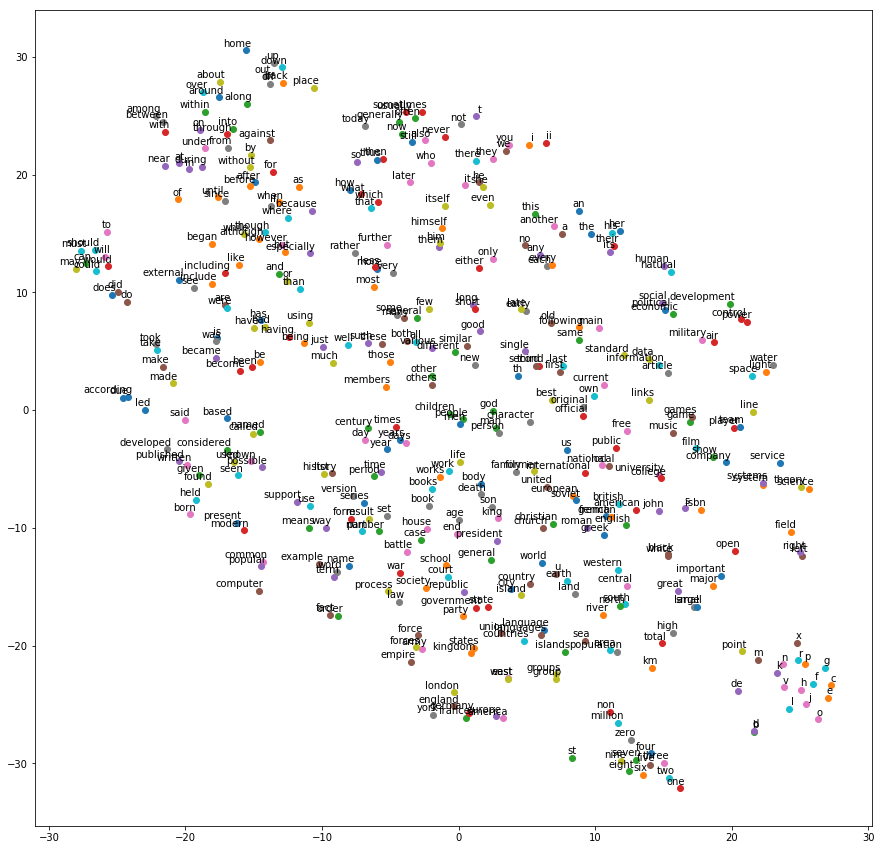

In [8]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)